# Analysis de los experimentos de Broadcasting

### Jorge Daniel Laborda
---
En este notebook se analizan los resultados de los experimentos de broadcasting. Hemos experimentado con dos tipos de Broadcasting:
* ALL_BROADCASTING: Al final de cada iteración cogemos todos los BNs generados por los procesos del cges y los fusionamos usando un ConsensusUnion. La red de consenso ahora se pasa a cada proceso de la siguiente iteración de forma que si el proceso obtiene un resultado peor en bdeu a la red de consenso, se sustituye por la red de consenso. El pseudocódigo de este algoritmo sería algo así:
   ```
   Inicio del Algoritmo CGES con All_Broadcasting:
   
   1. Realizar particiones y procesos circulares del algoritmo.
   
   2. Para cada iteración:
      a. Realizar el proceso de CGES en paralelo para generar BNs individuales.
      b. Al final de la iteración:
         - Fusionar todos los BNs generados utilizando ConsensusUnion.
         - Almacenar la red de consenso resultante.
   
      c. Para cada proceso en la siguiente iteración:
         i. Proporcionar la red de consenso como entrada al proceso además de la red del proceso previo.
         ii. Ejecutar el proceso CGES individualmente con la nueva entrada.
         iii. Comparar el resultado en términos de BDeu con la red de consenso.
         iv. Si el resultado del proceso es peor, reemplazar la red del proceso con la red de consenso.
   
   3. Repetir el ciclo hasta que se cumpla el criterio de convergencia.
   
   Fin del Algoritmo CGES con All_Broadcasting.
   ```

----------------------------------------------------------

* PAIR_BORADCASTING: Este cambio es un poco distinto al previo ya que toca directamente la fusión de cada proceso. En este caso, todas las redes generadas en cada iteración se comparten con las demás redes, para la siguiente iteración. Por lo tanto, en la fase de fusión del proceso circular están disponibles todas las redes generadas por los demás procesos. Ahora, la red construida por el proceso se fusiona con las demás redes a pares. Por ejemplo, si tenemos 4 procesos (A,B,C y D). En el proceso A están disponibles las redes de B, C y D. Las fusiones realizadas serían A con B, A con C y A con D. Se calcularía la puntuación bdeu de cada red generada, y el proceso se quedaría con la red con la mejor bdeu. Para refinar el proceso, aplicamos un BES al final. Después el proceso circular continua aplicando a esta red nueva un GES con los enlaces a los que está limitado y se repite hasta que haya una convergencia. 
El pseudocódigo quedaría algo así:
   ```
   Inicio del Algoritmo CGES con Pair Broadcasting:
   
   1. Realizar particiones y procesos circulares del algoritmo.
   
   2. Para cada iteración:
      a. Realizar el proceso de CGES en paralelo para generar BNs individuales.
      b. Al final de la iteración:
         - Compartir todas las redes generadas con los demás procesos.
         - Para cada proceso:
            i. Fusionar la red construida por el proceso con las demás redes a pares.
            ii. Calcular la puntuación BDeu de cada red resultante.
            iii. Seleccionar la red con la mejor puntuación BDeu y actualizar la red del proceso.
   
      c. Aplicar un BES a la red seleccionada por cada proceso.

      d.  Aplicar un GES a la red resultante, limitado a los enlaces permitidos.

      e.  Actualizar la red del proceso con el resultado del GES.
   
   3. Repetir el ciclo hasta que se cumpla el criterio de convergencia.
   
   Fin del Algoritmo CGES con Pair Broadcasting.
```



Los experimentos han utilizado los siguientes parámetros: algName,netName,clusteringName,numberOfRealThreads,convergence,broadcasting. 
Los valores de los parámetros son los siguientes:
* algName: CGES
* netName: Nombre de la red a utilizar. En este caso, se han usado las redes andes, link, pigs y munin.
* clusteringName: Nombre del clustering a utilizar. En este caso solo se ha usado el HierarchicalClustering.
* numberOfRealThreads: Número de hilos a utilizar. El número de particiones de enlace se elige con este valor. En este caso, se han usado 1,2,4 y 8 hilos.
* convergence: Criterio de convergencia. En este caso, se ha usado el criterio `c2` que comprueba si algún BN de la iteración actual es mejor a la mejor BN obtenida hasta el momento.
* broadcasting: Tipo de broadcasting a utilizar. En este caso, se han usado los tipos `ALL_BROADCASTING` y `PAIR_BROADCASTING`.

Los experimentos se han lanzado sobre un nodo cluster2 del supercomputador galgo (`select=1:ncpus=16:mem=32gb:cluster=galgo2`).

A continuación realizaremos el análisis de los resultados obtenidos.

In [2]:
# Imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [3]:
import pandas as pd

df = pd.read_csv('./results.csv')
# drop the columns clusteringName and convergence
#df = df.drop(['clusteringName', 'convergence'], axis=1)

# array of strings of parameters: algName, netName, clusteringName, numberOfRealThreads, convergence, broadcasting
param_columns = ["algName", "netName", "clusteringName", "numberOfRealThreads", "convergence", "broadcasting"]
#array of measurments:
measurement_columns = ["elapsedTime", "shd", "dfMM_avg", "dfMM_plus", "dfMM_minus", "iterations", "bdeu"]

# Dropping unnneccesary columns
df = df.drop(['algName','clusteringName', 'convergence'], axis=1)

# Rename elapsedTime to time
df = df.rename(columns={'elapsedTime': 'time', 'numberOfRealThreads' : 'threads'})


df.head()


,netName,threads,broadcasting,time,shd,dfMM_avg,dfMM_plus,dfMM_minus,iterations,bdeu
0,andes,1,ALL_BROADCASTING,14.016,149.0,322.0,0.0,0.0,4.0,-472072.842349
1,andes,1,ALL_BROADCASTING,11.691,150.0,326.0,0.0,0.0,4.0,-472011.273898
2,andes,1,ALL_BROADCASTING,12.200,136.0,294.0,0.0,0.0,5.0,-471837.045290
3,andes,1,ALL_BROADCASTING,14.625,156.0,336.0,10.0,10.0,4.0,-470899.402586
4,andes,1,ALL_BROADCASTING,11.183,150.0,322.0,10.0,10.0,4.0,-470960.838856


# Análisis Descriptivo

In [4]:
# Estadísticas descriptivas
desc_stats = df.groupby(['netName', 'threads', 'broadcasting'])['shd'].describe()

# Visualizar
print(desc_stats)

                                   count         mean         std     min  \
netName threads broadcasting                                                
andes   1       ALL_BROADCASTING    12.0   140.916667   34.623844    34.0   
                NO_BROADCASTING     12.0   140.916667   34.623844    34.0   
                PAIR_BROADCASTING   12.0   140.916667   34.623844    34.0   
        2       ALL_BROADCASTING    12.0   156.500000   40.236799    42.0   
                NO_BROADCASTING     12.0   150.250000   35.376225    42.0   
                PAIR_BROADCASTING   12.0   205.500000   45.908011   148.0   
        4       ALL_BROADCASTING    12.0   199.666667   51.291207   159.0   
                NO_BROADCASTING     12.0   167.166667   21.143808   145.0   
                PAIR_BROADCASTING   12.0   246.500000   47.868190   177.0   
        8       ALL_BROADCASTING    12.0   224.583333   48.240794   153.0   
                NO_BROADCASTING     12.0   168.000000   18.419357   136.0   

Faltan por lanzar estos experimentos:

In [5]:
# Experiments missing
count_not_12 = desc_stats[desc_stats['count'] != 12]
count_not_12.index

MultiIndex([( 'link', 4, 'PAIR_BROADCASTING'),
            ( 'link', 8, 'PAIR_BROADCASTING'),
            ('munin', 1,  'ALL_BROADCASTING'),
            ('munin', 1,   'NO_BROADCASTING'),
            ('munin', 1, 'PAIR_BROADCASTING'),
            ('munin', 2,  'ALL_BROADCASTING'),
            ('munin', 2,   'NO_BROADCASTING'),
            ('munin', 2, 'PAIR_BROADCASTING'),
            ('munin', 4,  'ALL_BROADCASTING'),
            ('munin', 4,   'NO_BROADCASTING'),
            ('munin', 4, 'PAIR_BROADCASTING'),
            ('munin', 8,  'ALL_BROADCASTING'),
            ('munin', 8,   'NO_BROADCASTING'),
            ('munin', 8, 'PAIR_BROADCASTING'),
            ( 'pigs', 8,  'ALL_BROADCASTING')],
           names=['netName', 'threads', 'broadcasting'])

# Visualización

In [31]:
def plot_barplot(network, x, y, hue):
    # Select the data for the specified network
    df_visualization = df.loc[df["netName"] == network].dropna()

    # Configure Seaborn
    sns.set(style="whitegrid")

    # Plot the barplot
    plt.figure(figsize=(12, 8))
    sns.barplot(x=x, y=y, hue=hue, data=df_visualization)
    plt.title(f'Distribution of {y} by {x} and {hue} for {network} network')
    plt.show()

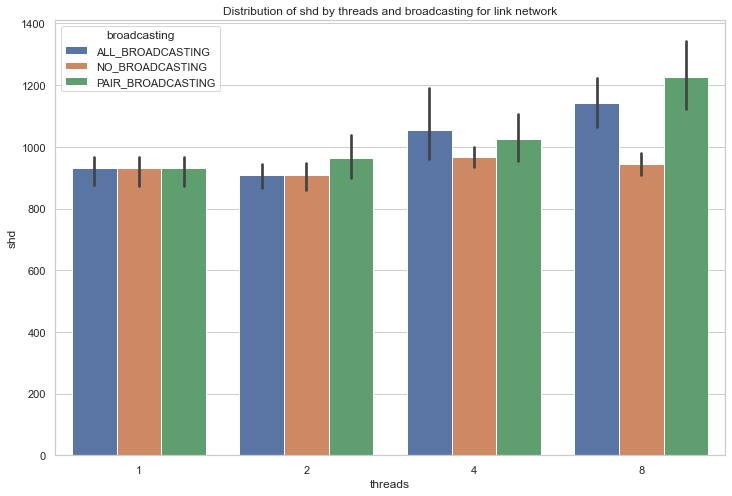

In [32]:
plot_barplot(network="link",x="threads", y="shd",hue="broadcasting")

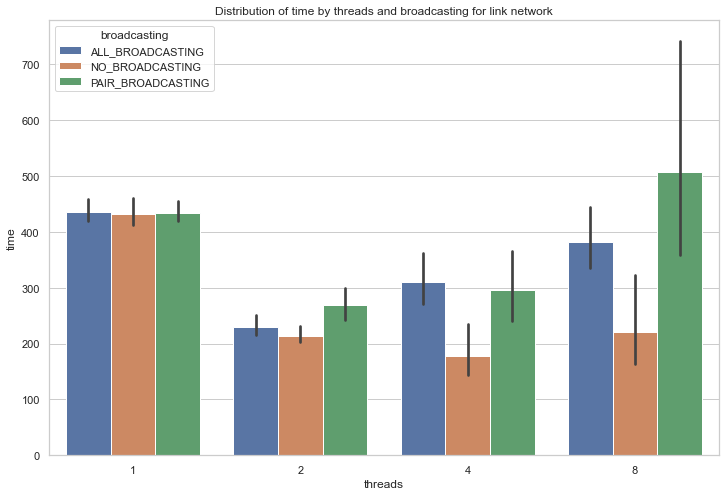

In [33]:
plot_barplot(network="link",x="threads", y="time",hue="broadcasting")

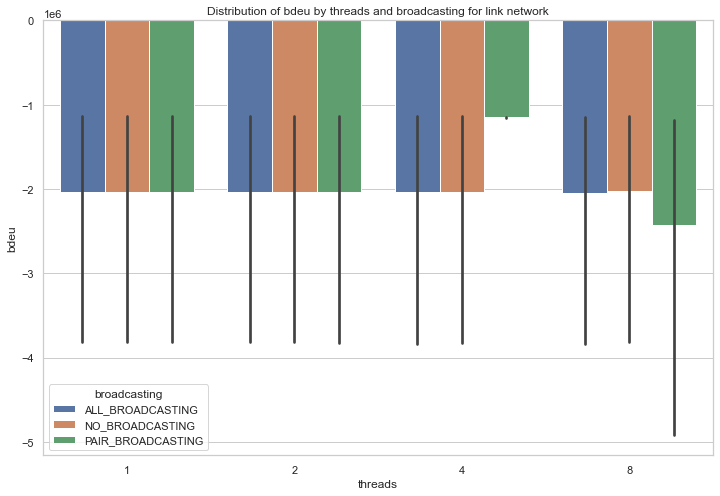

In [34]:
plot_barplot(network="link",x="threads", y="bdeu",hue="broadcasting")

In [41]:
df.loc[(df["netName"] == "link") & (df["broadcasting"] == "PAIR_BROADCASTING") & (df["threads"] == 2)]

,netName,threads,broadcasting,time,shd,dfMM_avg,dfMM_plus,dfMM_minus,iterations,bdeu,config
204,link,2,PAIR_BROADCASTING,278.801,1190.0,2742.0,1464.0,1464.0,6.0,-1.148586e+06,cges-2-PAIR_BROADCASTING
205,link,2,PAIR_BROADCASTING,219.121,835.0,1728.0,590.0,590.0,12.0,-1.135893e+06,cges-2-PAIR_BROADCASTING
206,link,2,PAIR_BROADCASTING,319.443,934.0,1914.0,626.0,626.0,23.0,-1.142578e+06,cges-2-PAIR_BROADCASTING
207,link,2,PAIR_BROADCASTING,289.347,1204.0,2700.0,1578.0,1578.0,9.0,-1.152036e+06,cges-2-PAIR_BROADCASTING
208,link,2,PAIR_BROADCASTING,228.862,839.0,1740.0,598.0,598.0,16.0,-1.136720e+06,cges-2-PAIR_BROADCASTING
209,link,2,PAIR_BROADCASTING,260.943,930.0,1914.0,690.0,690.0,21.0,-1.144549e+06,cges-2-PAIR_BROADCASTING
210,link,2,PAIR_BROADCASTING,379.701,1105.0,2342.0,992.0,992.0,4.0,-1.196743e+06,cges-2-PAIR_BROADCASTING
211,link,2,PAIR_BROADCASTING,311.772,927.0,1996.0,870.0,870.0,18.0,-1.137646e+06,cges-2-PAIR_BROADCASTING
212,link,2,PAIR_BROADCASTING,215.035,943.0,1986.0,736.0,736.0,12.0,-1.152563e+06,cges-2-PAIR_BROADCASTING
213,link,2,PAIR_BROADCASTING,223.537,849.0,1724.0,568.0,568.0,16.0,-1.129887e+06,cges-2-PAIR_BROADCASTING


# Tests Estadísticos

In [9]:
import pandas as pd
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Supongamos que df tiene las columnas 'config', 'Metrica1', 'Metrica2', ...
# donde 'Configuracion' es la variable categórica que representa cada configuración.

def compare_configurations(df):
    metrics = ['bdeu', 'shd', 'time']

    df["config"] = "cges-" + df['threads'].astype(str) + '-' + df['broadcasting']


    for metric in metrics:
        anova_result = f_oneway(*[df[df['config'] == config][metric] for config in df['config'].unique()])
        print(f"ANOVA para {metric}:")
        print(anova_result)
        print()

    for metric in metrics:
        tukey_result = pairwise_tukeyhsd(df[metric], df['config'])
        print(f"Prueba de Tukey para {metric}:")
        print(tukey_result)
        print()

# Supongamos que df es tu DataFrame
# compare_configurations(df)

In [10]:
compare_configurations(df)

ANOVA para bdeu:
F_onewayResult(statistic=nan, pvalue=nan)

ANOVA para shd:
F_onewayResult(statistic=nan, pvalue=nan)

ANOVA para time:
F_onewayResult(statistic=nan, pvalue=nan)

Prueba de Tukey para bdeu:
                 Multiple Comparison of Means - Tukey HSD, FWER=0.05                  
         group1                   group2            meandiff  p-adj lower upper reject
--------------------------------------------------------------------------------------
 cges-1-ALL_BROADCASTING   cges-1-NO_BROADCASTING    -19.5663   nan   nan   nan  False
 cges-1-ALL_BROADCASTING cges-1-PAIR_BROADCASTING      0.5119   nan   nan   nan  False
 cges-1-ALL_BROADCASTING  cges-2-ALL_BROADCASTING         nan   nan   nan   nan  False
 cges-1-ALL_BROADCASTING   cges-2-NO_BROADCASTING         nan   nan   nan   nan  False
 cges-1-ALL_BROADCASTING cges-2-PAIR_BROADCASTING -38846.8408   nan   nan   nan  False
 cges-1-ALL_BROADCASTING  cges-4-ALL_BROADCASTING         nan   nan   nan   nan  False
 cges-1-ALL

In [11]:
# Análisis de Convergencia
from scipy.stats import ttest_ind

# Comparación de dos configuraciones específicas (por ejemplo, ALL_BROADCASTING vs. PAIR_BROADCASTING)


config_1 = df[(df['broadcasting'] == 'ALL_BROADCASTING') & (df['threads'] == 1)]['bdeu']
config_2 = df[(df['broadcasting'] == 'PAIR_BROADCASTING') & (df['threads'] == 1)]['bdeu']

# Prueba t de muestras independientes
t_stat, p_value = ttest_ind(config_1, config_2)

# Visualizar resultados
print(f'Test t: {t_stat}, p-value: {p_value}')


Test t: -8.26301829836721e-07, p-value: 0.9999993424956186


In [12]:
df

,netName,threads,broadcasting,time,shd,dfMM_avg,dfMM_plus,dfMM_minus,iterations,bdeu,config
0,andes,1,ALL_BROADCASTING,14.016,149.0,322.0,0.0,0.0,4.0,-4.720728e+05,cges-1-ALL_BROADCASTING
1,andes,1,ALL_BROADCASTING,11.691,150.0,326.0,0.0,0.0,4.0,-4.720113e+05,cges-1-ALL_BROADCASTING
2,andes,1,ALL_BROADCASTING,12.200,136.0,294.0,0.0,0.0,5.0,-4.718370e+05,cges-1-ALL_BROADCASTING
3,andes,1,ALL_BROADCASTING,14.625,156.0,336.0,10.0,10.0,4.0,-4.708994e+05,cges-1-ALL_BROADCASTING
4,andes,1,ALL_BROADCASTING,11.183,150.0,322.0,10.0,10.0,4.0,-4.709608e+05,cges-1-ALL_BROADCASTING
...,...,...,...,...,...,...,...,...,...,...,...
500,pigs,8,PAIR_BROADCASTING,133.468,1.0,4.0,4.0,4.0,31.0,-1.675911e+06,cges-8-PAIR_BROADCASTING
501,pigs,8,PAIR_BROADCASTING,202.475,11.0,44.0,44.0,44.0,42.0,-1.678883e+06,cges-8-PAIR_BROADCASTING
502,pigs,8,PAIR_BROADCASTING,232.136,7.0,20.0,18.0,18.0,48.0,-1.676545e+06,cges-8-PAIR_BROADCASTING
503,pigs,8,PAIR_BROADCASTING,241.469,9.0,32.0,32.0,32.0,50.0,-1.676509e+06,cges-8-PAIR_BROADCASTING


## Exreport

In [13]:
df.head()

,netName,threads,broadcasting,time,shd,dfMM_avg,dfMM_plus,dfMM_minus,iterations,bdeu,config
0,andes,1,ALL_BROADCASTING,14.016,149.0,322.0,0.0,0.0,4.0,-472072.842349,cges-1-ALL_BROADCASTING
1,andes,1,ALL_BROADCASTING,11.691,150.0,326.0,0.0,0.0,4.0,-472011.273898,cges-1-ALL_BROADCASTING
2,andes,1,ALL_BROADCASTING,12.200,136.0,294.0,0.0,0.0,5.0,-471837.045290,cges-1-ALL_BROADCASTING
3,andes,1,ALL_BROADCASTING,14.625,156.0,336.0,10.0,10.0,4.0,-470899.402586,cges-1-ALL_BROADCASTING
4,andes,1,ALL_BROADCASTING,11.183,150.0,322.0,10.0,10.0,4.0,-470960.838856,cges-1-ALL_BROADCASTING


In [14]:
import os
import shutil
# Crear una copia de df llamada df_exreport
df_exreport = df.copy()

# Crear una columna con las configuraciones separadas por espacio. Los valores de las configuraciones están en las columnas threads y broadcasting
df_exreport['config'] = "cges-" + df_exreport['threads'].astype(str) + '-' + df_exreport['broadcasting']

# Eliminar las columnas threads y broadcasting
df_exreport = df_exreport.drop(['broadcasting'], axis=1)

df_exreport = df_exreport.groupby(["config", "netName"],observed=True).mean().reset_index()

# Redondear a 4
df_exreport = df_exreport.round(4)

# Write to csv ./exreport/exreport.csv
df_exreport.to_csv('./exreport/exreport.csv', index=False)

# Delete folder exreport_output and its content if exists
if os.path.exists('./exreport/exreport_output'):
    shutil.rmtree('./exreport/exreport_output')

# Execute exreport.r
os.system('Rscript ./exreport/exreport.r')


0

In [15]:
def generate_score_table(score_col):
    # Obtener las columnas de parámetros
    param_columns = ["algName", "netName", "clusteringName", "threads", "convergence", "broadcasting"]

    # Obtener las columnas del score
    columns = [col for col in df.columns if col.startswith(score_col)]

    # Obtener las columnas a eliminar
    columns_to_drop = [col for col in df.columns if col not in param_columns and col not in columns]

    # Eliminar las columnas
    df_unstack = df.drop(columns_to_drop, axis=1)

    # Añadir columna config
    df_unstack['config'] = "cges-" + df_unstack['threads'].astype(str) + '-' + df_unstack['broadcasting']

    # Eliminar las columnas threads y broadcasting
    df_unstack = df_unstack.drop(["threads", "broadcasting"], axis=1)

    table = df_unstack.groupby(["netName", "config"], observed=True).mean().unstack(0)
    table = table.transpose()

    # Changue index to network
    table.index = table.index.droplevel(0)

    # Ordering table
    table = table.reindex(['munin','pigs','link','andes'])

    # Capitalize the first letter of the network
    table.index = table.index.str.capitalize()

    return table

In [16]:
generate_score_table("shd")

config,cges-1-ALL_BROADCASTING,cges-1-NO_BROADCASTING,cges-1-PAIR_BROADCASTING,cges-2-ALL_BROADCASTING,cges-2-NO_BROADCASTING,cges-2-PAIR_BROADCASTING,cges-4-ALL_BROADCASTING,cges-4-NO_BROADCASTING,cges-4-PAIR_BROADCASTING,cges-8-ALL_BROADCASTING,cges-8-NO_BROADCASTING,cges-8-PAIR_BROADCASTING
netName,,,,,,,,,,,,
Munin,1461.545455,1461.090909,1461.454545,1501.750000,1511.333333,1541.333333,NaN,1569.000000,1649.571429,NaN,NaN,1559.000000
Pigs,0.000000,0.000000,0.000000,1.500000,1.833333,8.333333,12.916667,3.666667,6.333333,22.454545,5.916667,8.750000
Link,930.750000,930.750000,930.750000,909.666667,909.666667,963.750000,1055.416667,967.416667,1024.888889,1142.083333,943.250000,1227.555556
Andes,140.916667,140.916667,140.916667,156.500000,150.250000,205.500000,199.666667,167.166667,246.500000,224.583333,168.000000,251.583333
